In [1]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from collections import OrderedDict

from Joint_HDRDN import Joint_HDRDN
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

/home/asim/.conda/envs/asimenv_check/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/asim/.conda/envs/asimenv_check/lib/python3.13/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [2]:
npypath = '/data/asim/ISP/HDR_transformer/data/RAW/2022-0708-1630-2434.npz'
imdata = np.load(npypath)

sht = imdata['sht']
mid = imdata['mid']
lng = imdata['lng']
hdr = imdata['hdr']

crop_size = 992
H, W = hdr.shape[1], hdr.shape[2]
start_h = (H - crop_size) // 2
start_w = (W - crop_size) // 2

sht_crop = sht[:, start_h:start_h+crop_size, start_w:start_w+crop_size]
mid_crop = mid[:, start_h:start_h+crop_size, start_w:start_w+crop_size]
lng_crop = lng[:, start_h:start_h+crop_size, start_w:start_w+crop_size]
hdr_crop = hdr[:, start_h:start_h+crop_size, start_w:start_w+crop_size]

print(sht.shape, hdr.shape)

(8, 1728, 2304) (4, 1728, 2304)


In [3]:
def center_crop_div32(x):
    C, H, W = x.shape
    H32 = (H // 32) * 32
    W32 = (W // 32) * 32
    start_h = (H - H32) // 2
    start_w = (W - W32) // 2
    return x[:, start_h:start_h + H32, start_w:start_w + W32]
print(center_crop_div32(sht).shape)

(8, 1728, 2304)


In [4]:
def to_tensor(np_array):
    t = torch.from_numpy(np_array).float()
    return t

im1 = to_tensor(sht_crop).to(device).unsqueeze(0)
im2 = to_tensor(mid_crop).to(device).unsqueeze(0)
im3 = to_tensor(lng_crop).to(device).unsqueeze(0)
ref_hdr = to_tensor(hdr_crop).to(device).unsqueeze(0)
ref_hdr.shape

torch.Size([1, 4, 992, 992])

In [8]:
from debayer import Debayer5x5

debayer = Debayer5x5().cuda()  # or .to(device)

def bayer_to_rgb_torch(bayer_4ch):
    """
    Args:
        bayer_4ch: torch.Tensor of shape (B, 4, H, W), representing RGGB pattern
    Returns:
        rgb: torch.Tensor of shape (B, 3, 2H, 2W), gamma corrected
    """
    B, _, H, W = bayer_4ch.shape
    device = bayer_4ch.device

    # Assemble into Bayer mosaic
    bayer = torch.zeros((B, 1, H * 2, W * 2), dtype=bayer_4ch.dtype, device=device)
    bayer[:, :, 0::2, 0::2] = bayer_4ch[:, 0]  # R
    bayer[:, :, 0::2, 1::2] = bayer_4ch[:, 1]  # G1
    bayer[:, :, 1::2, 0::2] = bayer_4ch[:, 2]  # G2
    bayer[:, :, 1::2, 1::2] = bayer_4ch[:, 3]  # B

    # Demosaic
    rgb = debayer(bayer)

    # Clamp and apply gamma correction
    rgb = torch.clamp(rgb, 0.0, 1.0)
    rgb = rgb ** (1 / 2.2)

    return rgb


In [9]:
model = Joint_HDRDN(n_channel =8, out_channel = 4, embed_dim = 60, depths=[4, 4, 4])
model = nn.DataParallel(model)
# 2. Load state_dict from file
state_dict = torch.load('Joint_HDRDN.pth', map_location='cuda')  # load directly to GPU

model.load_state_dict(state_dict)


<All keys matched successfully>

In [10]:
model.eval()
with torch.no_grad():
    generate_hdr = model(im1, im2, im3)
generate_hdr.shape

torch.Size([1, 4, 992, 992])

In [11]:
im1_rgb = bayer_to_rgb_torch(im1[:, :4, :, :])
im2_rgb = bayer_to_rgb_torch(im2[:, :4, :, :])
im3_rgb = bayer_to_rgb_torch(im3[:, :4, :, :])
ref_hdr_rgb = bayer_to_rgb_torch(ref_hdr)
generate_hdr_rgb = bayer_to_rgb_torch(generate_hdr)
generate_hdr_rgb.shape

torch.Size([1, 3, 1984, 1984])

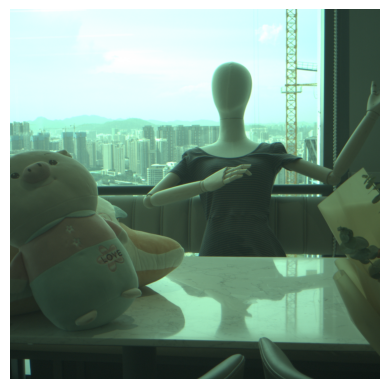

In [16]:


def show_tensor_image(img_tensor, save_path=None):
    """
    Displays and optionally saves a PyTorch image tensor.

    Args:
        img_tensor (torch.Tensor): Tensor of shape (C, H, W) or (1, C, H, W)
        save_path (str, optional): If provided, saves the image to this path
    """
    if img_tensor.dim() == 4:
        img_tensor = img_tensor[0]  # Take the first image from the batch

    # Convert to numpy image format (H, W, C)
    img_np = img_tensor.detach().cpu().numpy().transpose(1, 2, 0)
    img_np = img_np.clip(0, 1)  # Ensure values are in [0, 1] for imshow/imsave

    # Show the image
    plt.imshow(img_np)
    plt.axis('off')
    plt.show()

    # Save the image if path is given
    if save_path:
        plt.imsave(save_path, img_np)

show_tensor_image(im2_rgb, save_path='output.png')
